# Analysis of microarray - Vincent Dufour-Decieux

`%matplotlib inline` will allow to plot data directly inside the notebook.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


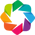

In [2]:
import holoviews as hv
import holoviews.util
from holoviews import streams
hv.extension('bokeh')

In [3]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

In [4]:
from IPython.display import HTML

In [6]:
cd ..

/Users/Espenel/Documents/bioimage-analysis/code_git/microarray_analysis_vincent


In [8]:
from io_czi import cziReader
from script.vincent import *

In [9]:
cd notebook

/Users/Espenel/Documents/bioimage-analysis/code_git/microarray_analysis_vincent/notebook


In [10]:
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.cmap'] = 'gray'

# Introduction

In Python, images are represented as `numpy` arrays. A single-channel, or grayscale, image is a 2D matrix of pixel intensities of shape `(row, column)`. We can construct a 3D volume as a series of 2D `planes`, giving 3D images the shape `(plane, row, column)`. Multichannel data adds a `channel` dimension in the final position containing color information. 

These conventions are summarized in the table below:


|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|
|3D grayscale|(plane, row, column)|
|3D multichannel|(plane, row, column, channel)|

In [11]:
path = "images"

In [12]:
filename = "2017.09.13_H1975_L858R_0cycles_FlatPCR_3510040--90.czi"

## Input/Output

Files in the .czi format can be loaded using the [czifile.py](https://www.lfd.uci.edu/~gohlke/code/czifile.py.html) from Christoph Gohlke.
> Note if your image are in .tif format they can be loaded with `skimage.io.imread` which will be faster

First we create a reader object:

In [13]:
reader = cziReader.CziReader(path + "/" + filename)

In [14]:
reader.czi.shape

(1, 1, 5, 9774, 11853, 1)

Second we applied the "load" method:

In [15]:
FAM, NA, HEX, CY5, DIC = reader.load()

# Metadata

Metadata are saved as a [XML.etree.ElemenTree](https://docs.python.org/2/library/xml.etree.elementtree.html) and can be access as follow:

Optionaly, we can use the "get_metadata" method to access the header of the czi file:

In [16]:
metadata = reader.get_metadata()

In [17]:
for element in metadata.iter():
    print("%s - %s" % (element.tag, element.text))

ImageDocument - 
  
Metadata - 
    
Experiment - 
      
RunMode - ValidateAndAdaptBeforePerformEnabled,OptimizeBeforePerformEnabled
BeforeHardwareSetting - Before Exp [DAPI]
AfterHardwareSetting - After Exp [DAPI]
ExperimentBlockIndex - 0
IsSegmented - false
IsStandardMode - true
ImageName - D:\Users\ooicc\Pictures\temp\Snap-05.czi
ImageTransferMode - MemoryMappedAndFileStream
AutoSave - 
        
StorageFolder - D:\Users\vdufourd\Pictures
Name - None
IsAutoSubFolder - true
IsAutoSubFolderExternal - true
IsClosedOnCompletion - false
SingleFileSaveFormat - TIFF
ConvertTo8Bit - false
AddXmlMetadata - false
ApplyDisplayMappings - false
SaveOriginalData - true
UseChannelNames - false
Quality - 100
CompressionMethod - None
SingleFileSaveDestinationFolder - D:\Users\vdufourd\Pictures
DimensionsForSeparateFolders - -C;-T;-Z;-S
Scripting - 
        
RunMacroBeforeExperiment - false
MacroBeforeExperiment - None
ErrorActionBeforeExperiment - ErrorAction_Continue
RunMacroAfterExperiment - false

Here we will crop the image to remove the edge where there is some evaporation effect. The function `crop_show()` will show which region was cropped (red square), `crop()` will be much faster but will not show the croped region.
> The size of the crop should stay 7000, otherwise it will mess up the rest of the analysis. 

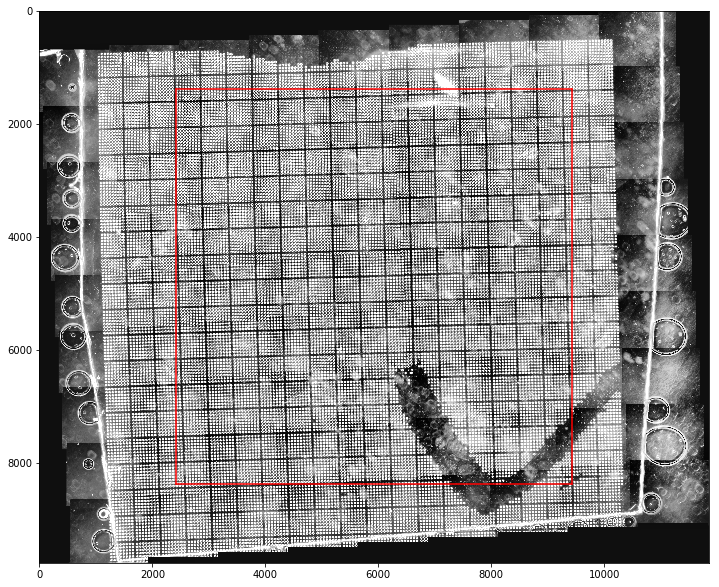

In [18]:
DIC_cropped = crop_show(DIC)

In [19]:
FAM_cropped = crop(FAM)
HEX_cropped = crop(HEX)

To accelerate the analysis we are cutting the image into 8 chunks:

In [20]:
chunks_img, x_block, y_block, overlap = chunks(DIC_cropped, overlap = 200, chunks = 8)

/Users/Espenel/anaconda/envs/vincent/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


We use the Canny filter to detect the edge of the wells

In [21]:
canny_lst = canny_chunks(chunks_img)

We use the Hough transform to find circle (well) in the image, more details [here](http://scikit-image.org/docs/dev/auto_examples/edges/plot_circular_elliptical_hough_transform.html).

In [22]:
hough_lst = hough_circle_chunk(canny_lst, low = 16, high = 22)

We can then draw circles using `skimage.draw.circle` everywhere we found a well:

In [23]:
circle_lst = draw_circle(canny_lst, hough_lst)

Finally we can stitch back the chuncks together and label the image (giving a different value for every circle):

In [24]:
labeled_img = stitched(canny_lst, circle_lst)

In [25]:
print("size of the image before cropping: {}, \n".format(DIC.shape) + 
       "after croping {}, \n".format(DIC_cropped.shape) + 
      "after finding the circle {}".format(labeled_img.shape))

size of the image before cropping: (9774, 11853), 
after croping (7000, 7000), 
after finding the circle (6530, 6500)


The function `show_RGB()` will use the module [holoviews](http://holoviews.org/) to show your image. The argument `s` allow you to down sample your image (to increase the speed). For example, s=8 will divide the resolution of your image by 8.

In [26]:
show_RGB(labeled_img, s = 8)

:RGB   [x,y]   (R,G,B)

The function `equaliz` ajust the contrast of the image as well as the size of it.

In [28]:
to_show_FAM, FAM_cropped_n = equaliz(FAM_cropped)

# Optional

The next few cells can be used to draw an ROI that you can exclude from the analysis in case some part of the microarray do not look good.

In [ ]:
data_1 = prop_lab(labeled_img)

In [ ]:
roi_to_rmv = []
def record_region(bounds):
    if 0 not in bounds:
        roi_to_rmv.append((bounds))   
    return label.select(x=(bounds[0], bounds[2]),y=(bounds[1], bounds[3]))

In [ ]:
image, label, box, bounds, dic = to_ROI(to_show_FAM, data_1)

In [ ]:
dmap = hv.DynamicMap(record_region, streams=[box])

In [ ]:
roi_to_rmv = []
(label * image * bounds * dmap).opts(dic)

In [ ]:
# JUST A GIF EXAMPLE OF WHAT IT LOOKS LIKE
HTML('<img src="images/roi.gif">')

In [ ]:
labeled_img = new_label_holo(roi_to_rmv, labeled_img, FAM_cropped_n)

Here we can see the region that have been removed from labeled image:

In [ ]:
show_RGB(labeled_img, s = 8)

# End optional:

Here we are going to measure the property (standard deviation, mean etc.) of the different well and create a [Pandas](https://pandas.pydata.org/) data frame with the data (a data frame is a two-dimensional data structure, i.e., data is aligned in a tabular fashion in rows and columns).
> Here you can measure the property of the different channel

In [31]:
to_show_HEX, HEX_cropped_n = equaliz(HEX_cropped)

The `prop_measure()` function can be user to measure the different property of the intensity image of interest, don't forget to `equaliz()` your image before you do the analysis. You can also choose to remove the background (back_sub = True or False) from your iamge. 

In [32]:
property_lst_FAM, props_FAM = prop_measure(labeled_img, FAM_cropped_n, back_sub = False)

In [33]:
property_lst_HEX, props_HEX = prop_measure(labeled_img, HEX_cropped_n, back_sub = False)

The data_panda() function will convert your "property" into a dataframe:

In [34]:
df_FAM = data_panda(property_lst_FAM)
df_HEX = data_panda(property_lst_HEX)

Finally you can chose to concatenate all the dataframes using the Pandas function `concat()`:

In [35]:
result = pd.concat([df_FAM, df_HEX], keys=['FAM', 'HEX'])

In [36]:
result

25th percentile   50th percentile   75th percentile   \
FAM 0                542.00             454.0            360.00   
    1                560.00             478.0            400.00   
    2                463.00             364.0            310.00   
    3                447.00             361.0            296.00   
    4                335.00             278.0            247.00   
    5                307.00             273.0            251.00   
    6                299.00             272.0            252.00   
    7                225.00             211.0            194.00   
    8                217.00             203.0            191.00   
    9                209.00             194.0            181.00   
    10               200.00             185.0            172.00   
    11               210.00             193.0            178.00   
    12               228.75             208.0            186.25   
    13               253.00             234.0            211.00   
    14               493.75             460.0            393.25   
    15              1218.00            1114.0            930.00   
    16               261.00             235.0            211.00   
    17               259.00             241.0            221.50   
    18               278.00             259.0            237.00   
    19               261.00             241.0            223.00   
    20               264.00             244.0            226.00   
    21               270.00             254.0            232.00   
    22               269.00             249.0            230.00   
    23               279.00             265.0            245.00   
    24               272.00             255.0            234.00   
    25               277.00             262.0            243.00   
    26               270.00             246.0            229.00   
    27               256.75             235.0            220.00   
    28               245.00             226.0            212.00   
    29               237.50             222.0            206.00   
...                     ...               ...               ...   
HEX 12294            200.00             164.0            152.00   
    12295            238.00             185.0            170.00   
    12296            210.00             171.0            156.00   
    12297            394.00             194.5            179.00   
    12298            322.00             190.0            175.00   
    12299            164.00             155.0            146.00   
    12300            166.00             157.0            148.00   
    12301            171.00             162.0            153.00   
    12302            167.00             157.0            150.00   
    12303            194.00             183.0            173.00   
    12304            345.00             214.0            194.00   
    12305            394.50             248.5            225.50   
    12306            178.00             170.5            163.00   
    12307            179.00             169.0            157.00   
    12308            229.00             203.0            190.00   
    12309            181.00             169.5            161.00   
    12310            175.00             165.0            155.00   
    12311            223.75             202.0            191.00   
    12312            177.00             168.0            159.00   
    12313            213.75             199.5            190.00   
    12314            208.00             200.0            187.50   
    12315            178.50             168.5            157.75   
    12316            168.50             159.0            153.00   
    12317            169.00             163.0            156.50   
    12318            206.50             195.0            179.50   
    12319            189.50             176.5            159.00   
    12320            181.00             174.0            162.00   
    12321            177.00             174.0            1

We can then save the data frame to csv:

In [37]:
#df.to_csv("100217.csv")

The function `plot_result()` allow to visualyze the results:

In [ ]:
plot_result(property_lst_FAM, props_FAM, to_show_FAM)

In [39]:
HTML('<img src="images/plot_result.gif">')

In [ ]:
plot_result(property_lst_HEX, props_HEX, to_show_HEX, dye = 'HEX')

In [40]:
HTML('<img src="images/plot_result2.gif">')